# Transfer learning & fine-tuning
Pokémon Classifier using Transfer Learning and Fine-tuning

Objective: Build a Pokémon classifier using transfer learning, fine-tuning and data augmentation techniques. The model should be able to distinguish between at least 3 different Pokémon species. You can pick any Pokémon from the data set.

Data Set: Pokémon Images First Generation: Link to Dataset

Submission:

- Provide a Jupyter notebook containing the model training code.
  - `transfer_learning_from_dir_sparse_categorical_crossentropy.ipynb`
- A Huggingface-Space link showcasing your deployed model.
  - https://huggingface.co/spaces/sonah5009/selfstudy
- In addition you have to provide following information about the model you trained:
    - the base model: `Xception`
    - What was the performance of the model after transfer-learning, before unfreezing the layers of the base model?: `code Reference`
  - What was the performance after fine-tuning?: `code Reference`
  - What Pokémon did you choose?: `Abra`, `Pikachu`, `Zubat`

## Setup

In [18]:
import tensorflow as tf
tf.__version__

'2.16.1'

In [19]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## An end-to-end example: fine-tuning an image classification model on pokemon

### Getting the data
80% for training, 20% for validation

In [20]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='mabel-poke/train',
  labels='inferred',
  label_mode='int',
  batch_size=12,
  image_size=(150, 150))

validation_ds = tf.keras.utils.image_dataset_from_directory(
  directory='mabel-poke/val',
  labels='inferred',
  label_mode='int',
  batch_size=12,
  image_size=(150, 150))


Found 295 files belonging to 3 classes.
Found 75 files belonging to 3 classes.


In [21]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [22]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of training batches: 25
Number of validation batches: 6
Number of test batches: 1


These are the first 9 images in the training dataset

2024-05-21 01:20:04.691050: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:04.767594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


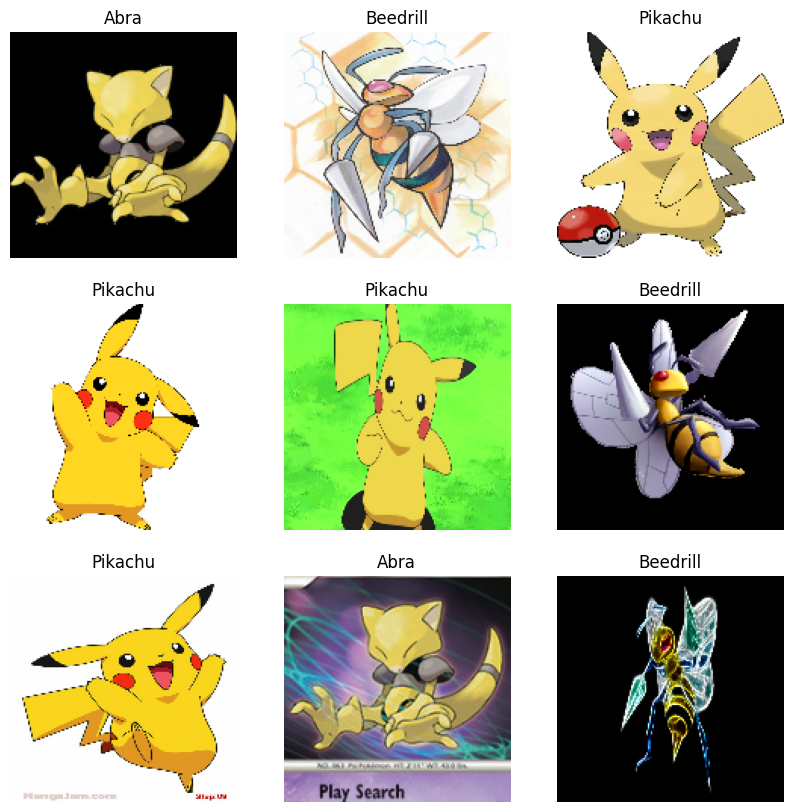

In [23]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
number_of_classes = len(train_ds.class_names)

In [25]:
number_of_classes

3

### Standardizing the data
resize images to 150x150:

In [26]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

### Using random data augmentation

In [27]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

Let's visualize what the first image of the first batch looks like after various random
 transformations:

2024-05-21 01:20:05.327118: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:05.435401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


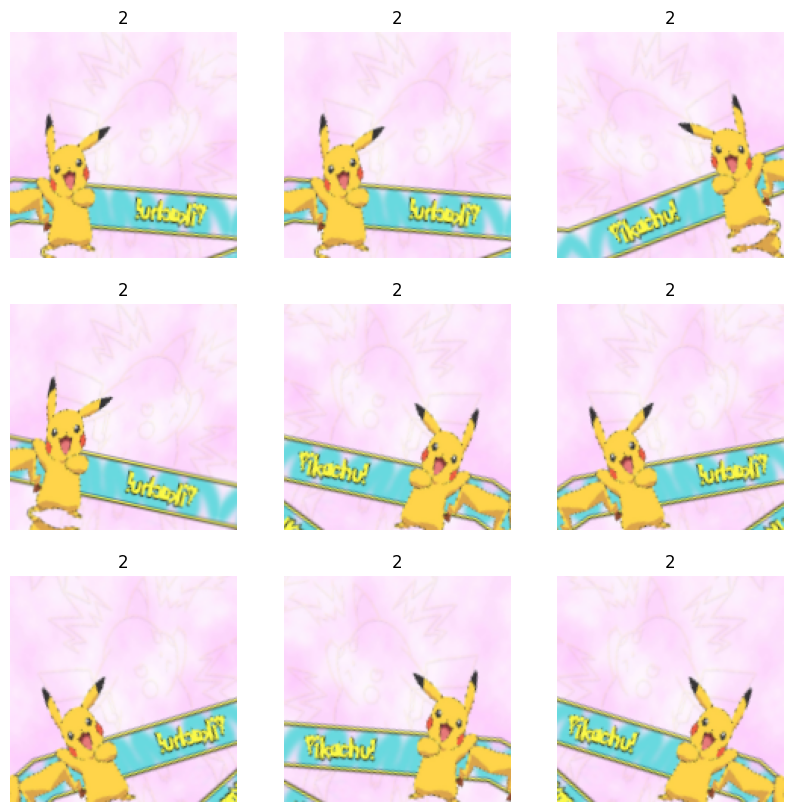

In [28]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## Build a model

Now let's built a model that follows the blueprint we've explained earlier.

Note that:

- We add a `Rescaling` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.

In [29]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_1 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 3)             │      6,147 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

## Train the top layer

In [30]:
model.compile(optimizer=keras.optimizers.Adam(),
loss="sparse_categorical_crossentropy",
metrics=['accuracy'])

initial_epochs = 4
print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/4


2024-05-21 01:20:09.646707: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:09.806657: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:09.825752: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:09.825767: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-21 01:20:09.856501: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:09.979364: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:09.998658: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:10.064010: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:32 4s/step - accuracy: 0.5000 - loss: 1.1645

2024-05-21 01:20:10.196550: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6324 - loss: 0.9605

2024-05-21 01:20:16.550581: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:16.610595: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:16.619014: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:16.637475: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 315ms/step - accuracy: 0.6359 - loss: 0.9535 - val_accuracy: 0.8413 - val_loss: 0.3682
Epoch 2/4


2024-05-21 01:20:17.955066: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:18.049594: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:18.049614: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-21 01:20:18.091309: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/25 ━━━━━━━━━━━━━━━━━━━━ 13s 580ms/step - accuracy: 0.8333 - loss: 0.4004

2024-05-21 01:20:18.391412: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:18.477511: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:18.572371: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/25 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.8542 - loss: 0.3789 

2024-05-21 01:20:18.624786: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:18.649368: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8672 - loss: 0.3670

2024-05-21 01:20:23.649825: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:23.677643: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:23.693256: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:23.721729: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - accuracy: 0.8677 - loss: 0.3661 - val_accuracy: 0.9048 - val_loss: 0.3022
Epoch 3/4


2024-05-21 01:20:24.960588: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:24.960606: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-21 01:20:24.974354: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:25.016786: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:25.300143: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:25.428163: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:25.448718: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/25 ━━━━━━━━━━━━━━━━━━━━ 14s 618ms/step - accuracy: 0.9167 - loss: 0.3937

2024-05-21 01:20:25.613393: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:25.700597: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9576 - loss: 0.2208

2024-05-21 01:20:31.066663: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:31.099530: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:31.120051: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:31.133960: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.9572 - loss: 0.2208 - val_accuracy: 0.9048 - val_loss: 0.2615
Epoch 4/4


2024-05-21 01:20:32.401735: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:32.545351: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:32.545382: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-21 01:20:32.711713: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:32.731689: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:32.777220: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:32.866162: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/25 ━━━━━━━━━━━━━━━━━━━━ 14s 584ms/step - accuracy: 0.8333 - loss: 0.2402

2024-05-21 01:20:32.980609: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:33.058778: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9262 - loss: 0.2057

2024-05-21 01:20:38.210680: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:38.247232: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:38.266395: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:38.267711: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.9267 - loss: 0.2052 - val_accuracy: 0.9048 - val_loss: 0.2279


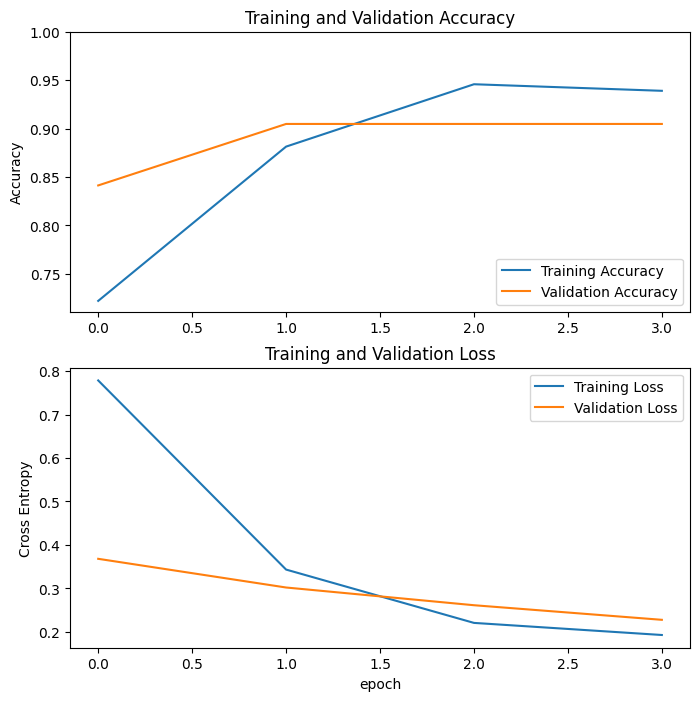

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Do a round of fine-tuning of the entire model

In [32]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

epochs = 1
print("Fitting the end-to-end model")
history_fine = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_1 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 3)             │      6,147 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,879,923 (79.65 MB)

 Trainable params: 20,813,099 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 12,296 (48.04 KB)

Fitting the end-to-end model


2024-05-21 01:20:57.544627: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:57.705056: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:57.858681: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:57.858700: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-05-21 01:20:58.079418: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:58.240500: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:58.243444: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:58.247370: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:20:58.266818: W tensorflow/core/lib/png/png_io.cc:89] PN

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.5137 - loss: 0.9364

2024-05-21 01:21:21.710637: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:21:21.763802: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:21:21.811827: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:21:21.819178: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5154 - loss: 0.9345 - val_accuracy: 0.9524 - val_loss: 0.2014


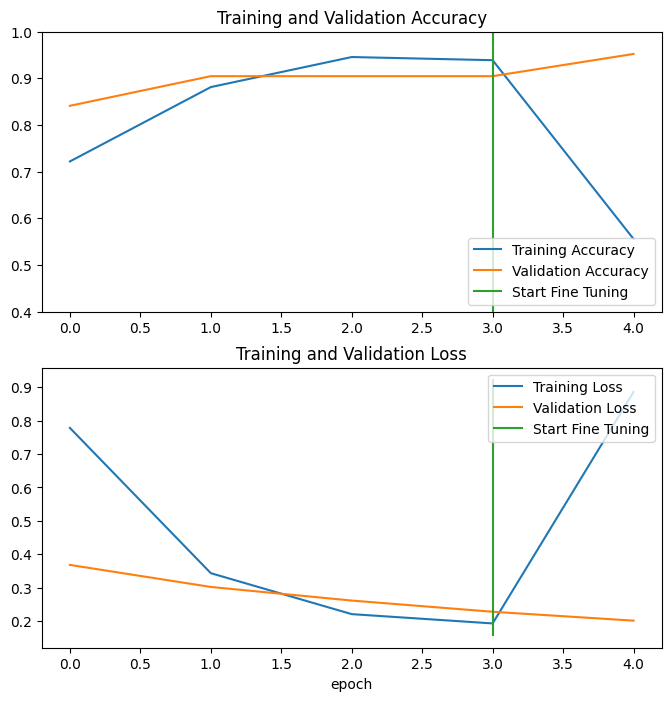

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1]) # set the y-axis limits
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

After 10 epochs, fine-tuning gains us a nice improvement here.
Let's evaluate the model on the test dataset:

In [34]:
# print("Test dataset evaluation")
model.evaluate(test_ds)

2024-05-21 01:21:23.435466: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 1.0000 - loss: 0.1327


[0.13268093764781952, 1.0]

2024-05-21 01:21:23.726571: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:21:23.777183: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:21:23.811472: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-05-21 01:21:23.816075: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


Predictions:
 [1 2 2 2 0 1 2 2 1 2 2 2]
Labels:
 [1 2 2 0 0 1 2 2 1 2 2 2]


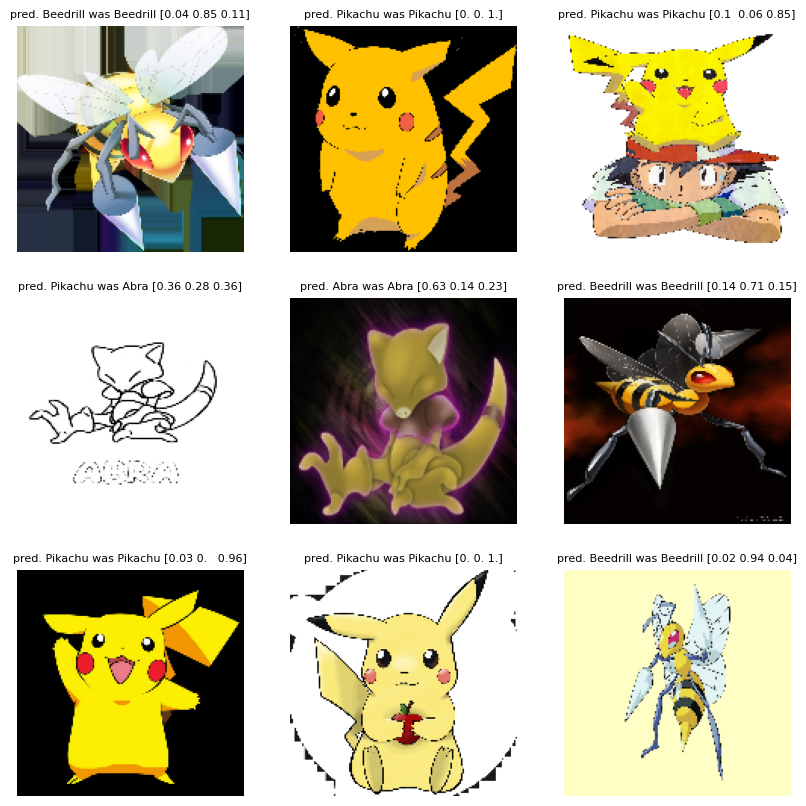

In [35]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions_in_percentage = model.predict_on_batch(image_batch)
# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = np.argmax(predictions_in_percentage, axis=-1)
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('pred. ' + class_names[predictions[i]] + ' was ' + class_names[label_batch[i]] + ' ' + 	str(np.round(predictions_in_percentage[i], 2)), fontsize=8)
  plt.axis("off")

In [36]:
model.save('mabel_transferlearning.keras')